In [45]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [71]:
# Create Tensors to hold input and outputs.
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))


#第一组参数
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,-8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

#第二组参数
beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))


beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=5

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [72]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [73]:
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

tensor(0.2250, dtype=torch.float64)

tensor(0.2174, dtype=torch.float64)

tensor(0.2192, dtype=torch.float64)

(raylet) [2022-11-13 19:23:49,553 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 300826624; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:23:59,563 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 300740608; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:24:09,572 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 300699648; capacity: 29394726912. Object creation will fail if spilling is required.


In [49]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [50]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=5
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr,ga= config["lambda1"], config["lambda2"],config["lr"],config["ga"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.6,0.7,0.8]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "ga":tune.choice([0.3,0.4,0.5])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=96)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)
# 0.3,0.4,0.5

Trial name,status,loc,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_9238f_00000,TERMINATED,10.224.0.12:29861,0.3,0.05,0.001,0.8,1,12.7455,1.48136
train_model_9238f_00001,TERMINATED,10.224.0.12:30472,0.4,0.03,0.002,0.8,1,12.4823,1.40025
train_model_9238f_00002,TERMINATED,10.224.0.12:30473,0.3,0.05,0.002,0.8,1,12.542,1.48006
train_model_9238f_00003,TERMINATED,10.224.0.12:30475,0.4,0.05,0.003,0.8,1,12.5766,1.33738
train_model_9238f_00004,TERMINATED,10.224.0.12:30477,0.4,0.03,0.001,0.8,1,13.0413,1.3894
train_model_9238f_00005,TERMINATED,10.224.0.12:30479,0.3,0.03,0.003,0.6,1,12.4407,1.58983
train_model_9238f_00006,TERMINATED,10.224.0.12:30481,0.5,0.03,0.001,0.7,1,12.2821,1.39378
train_model_9238f_00007,TERMINATED,10.224.0.12:30483,0.3,0.05,0.002,0.8,1,12.3979,1.48006
train_model_9238f_00008,TERMINATED,10.224.0.12:30485,0.3,0.04,0.001,0.7,1,12.8742,1.50847
train_model_9238f_00009,TERMINATED,10.224.0.12:30488,0.3,0.05,0.001,0.6,1,12.3618,1.62748


(raylet) [2022-11-13 16:45:50,885 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 379994112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:46:00,902 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 378982400; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9238f_00000:
  date: 2022-11-13_16-46-03
  done: false
  experiment_id: deba72a4d15e4a56991c3bebcd3c9e1e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4813630342483521
  node_ip: 10.224.0.12
  pid: 29861
  time_since_restore: 12.74553656578064
  time_this_iter_s: 12.74553656578064
  time_total_s: 12.74553656578064
  timestamp: 1668329163
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00000
  warmup_time: 0.0033888816833496094
  
Result for train_model_9238f_00000:
  date: 2022-11-13_16-46-03
  done: true
  experiment_id: deba72a4d15e4a56991c3bebcd3c9e1e
  experiment_tag: 0_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4813630342483521
  node_ip: 10.224.0.12
  pid: 29861
  time_since_restore: 12.74553656578064
  time_this_iter_s: 12.74553656578064
  time_total_s: 12.74553656578064
  timestamp: 1668329163
  timesteps_

Result for train_model_9238f_00002:
  date: 2022-11-13_16-46-07
  done: false
  experiment_id: b1ada5c6560f4d6895f59d2bc5ebd807
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4800578355789185
  node_ip: 10.224.0.12
  pid: 30473
  time_since_restore: 12.541959047317505
  time_this_iter_s: 12.541959047317505
  time_total_s: 12.541959047317505
  timestamp: 1668329167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00002
  warmup_time: 0.00661015510559082
  
Result for train_model_9238f_00001:
  date: 2022-11-13_16-46-07
  done: false
  experiment_id: 7d070543f55f4e3f9ce073c5ba30ff9c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.400252604484558
  node_ip: 10.224.0.12
  pid: 30472
  time_since_restore: 12.482312202453613
  time_this_iter_s: 12.482312202453613
  time_total_s: 12.482312202453613
  timestamp: 1668329167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00001
 

Result for train_model_9238f_00010:
  date: 2022-11-13_16-46-07
  done: true
  experiment_id: bb0b397294384b52bfdef292449c655a
  experiment_tag: 10_ga=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4655643939971923
  node_ip: 10.224.0.12
  pid: 30490
  time_since_restore: 12.44642949104309
  time_this_iter_s: 12.44642949104309
  time_total_s: 12.44642949104309
  timestamp: 1668329167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00010
  warmup_time: 0.005040407180786133
  
Result for train_model_9238f_00009:
  date: 2022-11-13_16-46-07
  done: true
  experiment_id: fe089d369d4749d69abe4763d1de05e1
  experiment_tag: 9_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6274758577346802
  node_ip: 10.224.0.12
  pid: 30488
  time_since_restore: 12.361820936203003
  time_this_iter_s: 12.361820936203003

Result for train_model_9238f_00020:
  date: 2022-11-13_16-46-07
  done: true
  experiment_id: cfad06ecec1b4c59ac833926e388040f
  experiment_tag: 20_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5422909259796143
  node_ip: 10.224.0.12
  pid: 30516
  time_since_restore: 12.446752309799194
  time_this_iter_s: 12.446752309799194
  time_total_s: 12.446752309799194
  timestamp: 1668329167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00020
  warmup_time: 0.010890960693359375
  
Result for train_model_9238f_00027:
  date: 2022-11-13_16-46-07
  done: false
  experiment_id: d91b9842691f4490ad5f67f5d1694d65
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.515731930732727
  node_ip: 10.224.0.12
  pid: 30530
  time_since_restore: 12.535772562026978
  time_this_iter_s: 12.535772562026978
  time_total_s: 12.535772562026978
  timestamp: 1668329167
  times

(raylet) [2022-11-13 16:46:10,914 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 378015744; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9238f_00032:
  date: 2022-11-13_16-46-15
  done: false
  experiment_id: deba72a4d15e4a56991c3bebcd3c9e1e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5864792585372924
  node_ip: 10.224.0.12
  pid: 29861
  time_since_restore: 11.650995969772339
  time_this_iter_s: 11.650995969772339
  time_total_s: 11.650995969772339
  timestamp: 1668329175
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00032
  warmup_time: 0.0033888816833496094
  
Result for train_model_9238f_00032:
  date: 2022-11-13_16-46-15
  done: true
  experiment_id: deba72a4d15e4a56991c3bebcd3c9e1e
  experiment_tag: 32_ga=0.5000,lambda1=0.0400,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5864792585372924
  node_ip: 10.224.0.12
  pid: 29861
  time_since_restore: 11.650995969772339
  time_this_iter_s: 11.650995969772339
  time_total_s: 11.650995969772339
  timestamp: 1668329175
  tim

Result for train_model_9238f_00040:
  date: 2022-11-13_16-46-19
  done: false
  experiment_id: 033e470e40f94e649f6ad1ba07fca5cd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6038012027740478
  node_ip: 10.224.0.12
  pid: 30520
  time_since_restore: 11.703037738800049
  time_this_iter_s: 11.703037738800049
  time_total_s: 11.703037738800049
  timestamp: 1668329179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00040
  warmup_time: 0.004606962203979492
  
Result for train_model_9238f_00045:
  date: 2022-11-13_16-46-19
  done: false
  experiment_id: 2a63bd8dcd844959ac7e01223221ceba
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5959716081619262
  node_ip: 10.224.0.12
  pid: 30512
  time_since_restore: 11.596315383911133
  time_this_iter_s: 11.596315383911133
  time_total_s: 11.596315383911133
  timestamp: 1668329179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00045

Result for train_model_9238f_00050:
  date: 2022-11-13_16-46-19
  done: false
  experiment_id: c4b232f37c1849ee975fdff310d36a77
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6924493789672852
  node_ip: 10.224.0.12
  pid: 30485
  time_since_restore: 12.093117237091064
  time_this_iter_s: 12.093117237091064
  time_total_s: 12.093117237091064
  timestamp: 1668329179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00050
  warmup_time: 0.008543968200683594
  
Result for train_model_9238f_00057:
  date: 2022-11-13_16-46-19
  done: false
  experiment_id: b1cb706fa1d14196a8127ad8d8e981fd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3574347019195556
  node_ip: 10.224.0.12
  pid: 30532
  time_since_restore: 11.899494171142578
  time_this_iter_s: 11.899494171142578
  time_total_s: 11.899494171142578
  timestamp: 1668329179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00057

Result for train_model_9238f_00058:
  date: 2022-11-13_16-46-20
  done: false
  experiment_id: 3ee3b1ab5b3948ca8e2d90ffbae8bb27
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5422909259796143
  node_ip: 10.224.0.12
  pid: 30504
  time_since_restore: 12.66026520729065
  time_this_iter_s: 12.66026520729065
  time_total_s: 12.66026520729065
  timestamp: 1668329180
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00058
  warmup_time: 0.009207010269165039
  
Result for train_model_9238f_00058:
  date: 2022-11-13_16-46-20
  done: true
  experiment_id: 3ee3b1ab5b3948ca8e2d90ffbae8bb27
  experiment_tag: 58_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5422909259796143
  node_ip: 10.224.0.12
  pid: 30504
  time_since_restore: 12.66026520729065
  time_this_iter_s: 12.66026520729065
  time_total_s: 12.66026520729065
  timestamp: 1668329180
  timesteps_

(raylet) [2022-11-13 16:46:20,947 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 376811520; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9238f_00064:
  date: 2022-11-13_16-46-26
  done: false
  experiment_id: deba72a4d15e4a56991c3bebcd3c9e1e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6353197336196899
  node_ip: 10.224.0.12
  pid: 29861
  time_since_restore: 11.361870288848877
  time_this_iter_s: 11.361870288848877
  time_total_s: 11.361870288848877
  timestamp: 1668329186
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00064
  warmup_time: 0.0033888816833496094
  
Result for train_model_9238f_00064:
  date: 2022-11-13_16-46-26
  done: true
  experiment_id: deba72a4d15e4a56991c3bebcd3c9e1e
  experiment_tag: 64_ga=0.5000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6353197336196899
  node_ip: 10.224.0.12
  pid: 29861
  time_since_restore: 11.361870288848877
  time_this_iter_s: 11.361870288848877
  time_total_s: 11.361870288848877
  timestamp: 1668329186
  tim

Result for train_model_9238f_00080:
  date: 2022-11-13_16-46-30
  done: false
  experiment_id: cfad06ecec1b4c59ac833926e388040f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3459979176521302
  node_ip: 10.224.0.12
  pid: 30516
  time_since_restore: 11.349372386932373
  time_this_iter_s: 11.349372386932373
  time_total_s: 11.349372386932373
  timestamp: 1668329190
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00080
  warmup_time: 0.010890960693359375
  
Result for train_model_9238f_00080:
  date: 2022-11-13_16-46-30
  done: true
  experiment_id: cfad06ecec1b4c59ac833926e388040f
  experiment_tag: 80_ga=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3459979176521302
  node_ip: 10.224.0.12
  pid: 30516
  time_since_restore: 11.349372386932373
  time_this_iter_s: 11.349372386932373
  time_total_s: 11.349372386932373
  timestamp: 1668329190
  time

(raylet) [2022-11-13 16:46:30,963 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 376266752; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_9238f_00081:
  date: 2022-11-13_16-46-31
  done: true
  experiment_id: dceebfad12984509be0cc7f8c7e7d238
  experiment_tag: 81_ga=0.5000,lambda1=0.0300,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3184496641159058
  node_ip: 10.224.0.12
  pid: 30524
  time_since_restore: 11.421891689300537
  time_this_iter_s: 11.421891689300537
  time_total_s: 11.421891689300537
  timestamp: 1668329191
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00081
  warmup_time: 0.004946708679199219
  
Result for train_model_9238f_00087:
  date: 2022-11-13_16-46-31
  done: false
  experiment_id: b1cb706fa1d14196a8127ad8d8e981fd
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5864792585372924
  node_ip: 10.224.0.12
  pid: 30532
  time_since_restore: 11.267273187637329
  time_this_iter_s: 11.267273187637329
  time_total_s: 11.267273187637329
  timestamp: 1668329191
  time

Result for train_model_9238f_00088:
  date: 2022-11-13_16-46-31
  done: false
  experiment_id: dc067f1173e04d59b5d29e95e912d333
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6032796859741212
  node_ip: 10.224.0.12
  pid: 30534
  time_since_restore: 11.61122727394104
  time_this_iter_s: 11.61122727394104
  time_total_s: 11.61122727394104
  timestamp: 1668329191
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9238f_00088
  warmup_time: 0.005112409591674805
  
Result for train_model_9238f_00088:
  date: 2022-11-13_16-46-31
  done: true
  experiment_id: dc067f1173e04d59b5d29e95e912d333
  experiment_tag: 88_ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6032796859741212
  node_ip: 10.224.0.12
  pid: 30534
  time_since_restore: 11.61122727394104
  time_this_iter_s: 11.61122727394104
  time_total_s: 11.61122727394104
  timestamp: 1668329191
  timesteps_

2022-11-13 16:46:32,287	INFO tune.py:758 -- Total run time: 43.68 seconds (43.48 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
9238f_00000          1.481363         12.745537  True            None   
9238f_00001          1.400253         12.482312  True            None   
9238f_00002          1.480058         12.541959  True            None   
9238f_00003          1.337375         12.576589  True            None   
9238f_00004          1.389402         13.041342  True            None   
...                       ...               ...   ...             ...   
9238f_00091          1.412662         11.702757  True            None   
9238f_00092          1.327792         11.092958  True            None   
9238f_00093          1.481363         11.403551  True            None   
9238f_00094          1.404924         10.917534  True            None   
9238f_00095          1.385474         11.330494  True            N

(raylet) [2022-11-13 16:46:40,972 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 375767040; capacity: 29394726912. Object creation will fail if spilling is required.


In [51]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.3184496641159058


{'lr': 0.8, 'lambda1': 0.03, 'lambda2': 0.001, 'ga': 0.5}

In [52]:
################## second step##################

prior=5
#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
# lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
lambda1,lambda2,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1048, grad_fn=<AddBackward0>)

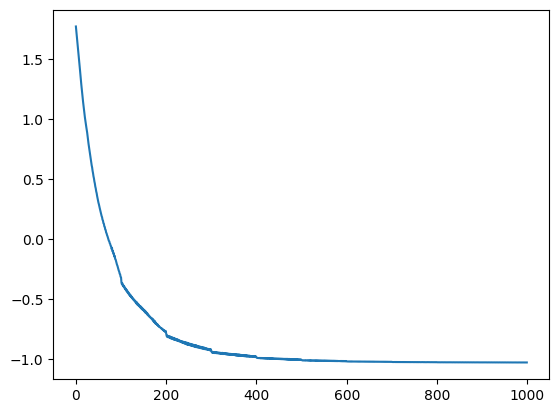

In [53]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [54]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.7198e+00, -1.1631e+00, -1.2482e+00, -1.6908e+00, -1.0773e+00,
         -3.1015e-01, -4.3927e-01, -2.2658e-01, -3.2237e-01,  4.7317e-01,
          2.7723e-05, -3.1060e-05,  1.9437e-05,  3.7040e-06, -1.9149e-05,
         -2.1793e-05, -2.4664e-05,  4.4003e-05, -6.2759e-05,  9.7817e-05,
          1.2331e-04,  4.2059e-05, -4.5336e-05, -1.1906e-04, -3.2754e-05,
          6.6762e-06,  8.3566e-05, -8.8606e-06, -9.1293e-05,  2.5986e-05,
          1.6835e-05,  1.2582e-04,  7.5326e-02,  5.2201e-05,  8.3639e-05,
         -5.7129e-05,  2.0592e-05, -2.7824e-05, -1.1436e-04, -1.5305e-05,
          1.7927e-05, -1.6410e-05, -1.7687e-06, -1.0267e-04, -8.3123e-05,
         -3.0824e-05,  2.8516e-05,  2.9830e-05,  1.0478e-05,  1.3970e-05,
          6.6487e-05, -7.2981e-05, -1.1186e-06, -6.7897e-05,  5.0131e-05,
          1.2356e-04,  1.2375e-04, -1.1414e-04, -1.1980e-04,  5.4894e-05,
          2.9833e-05, -1.1014e-04, -2.8851e-02, -9.7703e-05, -2.0313e-05,
         -6.0510e-05,  6.6511e-05, -9.

tensor([[-1.7198e+00, -1.1631e+00, -1.2482e+00, -1.6908e+00, -1.0773e+00,
         -3.1015e-01, -4.3927e-01, -2.2658e-01, -3.2237e-01,  4.7317e-01,
          2.7723e-05, -3.1060e-05,  1.9437e-05,  3.7040e-06, -1.9149e-05,
         -2.1793e-05, -2.4664e-05,  4.4003e-05, -6.2759e-05,  9.7817e-05,
          1.2331e-04,  4.2059e-05, -4.5336e-05, -1.1906e-04, -3.2754e-05,
          6.6762e-06,  8.3566e-05, -8.8606e-06, -9.1293e-05,  2.5986e-05,
          1.6835e-05,  1.2582e-04,  7.5326e-02,  5.2201e-05,  8.3639e-05,
         -5.7129e-05,  2.0592e-05, -2.7824e-05, -1.1436e-04, -1.5305e-05,
          1.7927e-05, -1.6410e-05, -1.7687e-06, -1.0267e-04, -8.3123e-05,
         -3.0824e-05,  2.8516e-05,  2.9830e-05,  1.0478e-05,  1.3970e-05,
          6.6487e-05, -7.2981e-05, -1.1186e-06, -6.7897e-05,  5.0131e-05,
          1.2356e-04,  1.2375e-04, -1.1414e-04, -1.1980e-04,  5.4894e-05,
          2.9833e-05, -1.1014e-04, -2.8851e-02, -9.7703e-05, -2.0313e-05,
         -6.0510e-05,  6.6511e-05, -9.

tensor([[-1.6560e+00, -1.1448e+00, -1.2587e+00, -1.6734e+00, -1.0878e+00,
         -3.6201e-01, -6.0382e-01, -3.8475e-01, -4.5934e-01,  6.6965e-01,
          1.4313e-05,  8.9001e-06, -2.6032e-06,  3.8721e-05,  7.9214e-07,
         -3.7442e-06, -2.0674e-06,  3.3541e-06,  2.6803e-05, -3.8348e-05,
         -1.0537e-05, -4.5759e-06, -7.5043e-05,  3.0272e-02,  1.5455e-05,
         -2.5435e-06, -2.5087e-06, -1.2607e-05,  1.2403e-06, -6.6442e-06,
         -1.0626e-05, -2.1369e-05,  1.3304e-01,  8.7071e-07, -1.6513e-06,
         -2.8159e-05,  2.5991e-06,  3.6275e-06, -8.9450e-06, -4.1186e-06,
         -4.6377e-06,  1.8197e-06,  8.4064e-06,  1.0363e-05, -4.1202e-05,
         -1.6224e-05, -5.9463e-06,  1.0668e-05, -8.5855e-06,  7.1524e-06,
          2.1780e-06, -7.2050e-05,  3.8212e-06,  4.8833e-06, -2.9470e-05,
          3.3445e-05,  4.3762e-07,  2.0982e-06,  3.8567e-06, -4.2129e-05,
         -6.8131e-06,  6.7450e-07, -2.3272e-02, -4.9802e-07, -5.5532e-06,
         -1.8876e-05, -1.0672e-05, -3.

(raylet) [2022-11-13 16:46:50,981 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 375705600; capacity: 29394726912. Object creation will fail if spilling is required.


In [55]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.1048)

tensor(0.0510)

tensor(0.0066)

tensor(0.0472)

In [56]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[82,  0],
       [ 1, 77]])

array([[85,  0],
       [ 0, 75]])

array([[72,  0],
       [ 1, 87]])

In [57]:
################## third step##################
##为缩短运行时间，将lambda2固定##

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=3)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         "lr":tune.choice([0.6,0.7,0.8])
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_bb046_00000,TERMINATED,10.224.0.12:32094,0.8,0.05,0.001,0.6,1,15.6193,0.923814
train_model_bb046_00001,TERMINATED,10.224.0.12:32568,0.2,0.03,0.002,0.7,1,15.6321,0.872476
train_model_bb046_00002,TERMINATED,10.224.0.12:32570,0.1,0.04,0.002,0.7,1,15.051,0.885513
train_model_bb046_00003,TERMINATED,10.224.0.12:32572,0.7,0.04,0.001,0.7,1,15.0479,0.900688
train_model_bb046_00004,TERMINATED,10.224.0.12:32574,0.5,0.03,0.002,0.8,1,15.9753,0.878561
train_model_bb046_00005,TERMINATED,10.224.0.12:32576,0.1,0.05,0.003,0.6,1,15.2765,0.890002
train_model_bb046_00006,TERMINATED,10.224.0.12:32578,0.6,0.04,0.001,0.8,1,15.3169,0.902073
train_model_bb046_00007,TERMINATED,10.224.0.12:32580,0.2,0.04,0.002,0.7,1,15.5473,0.885455
train_model_bb046_00008,TERMINATED,10.224.0.12:32582,0.5,0.03,0.001,0.8,1,14.6875,0.890425
train_model_bb046_00009,TERMINATED,10.224.0.12:32584,0.8,0.05,0.003,0.8,1,15.1239,0.938149


(raylet) [2022-11-13 16:47:00,995 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 374415360; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:47:11,002 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 374235136; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_bb046_00000:
  date: 2022-11-13_16-47-15
  done: false
  experiment_id: f16fd93607a24f3a80817772458316b4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9238137877208936
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 15.619259119033813
  time_this_iter_s: 15.619259119033813
  time_total_s: 15.619259119033813
  timestamp: 1668329235
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00000
  warmup_time: 0.0037298202514648438
  
Result for train_model_bb046_00000:
  date: 2022-11-13_16-47-15
  done: true
  experiment_id: f16fd93607a24f3a80817772458316b4
  experiment_tag: 0_eta=0.8000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9238137877208936
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 15.619259119033813
  time_this_iter_s: 15.619259119033813
  time_total_s: 15.619259119033813
  timestamp: 1668329235
  times

Result for train_model_bb046_00022:
  date: 2022-11-13_16-47-18
  done: true
  experiment_id: 3286bb2915a7480abca82672b75cb331
  experiment_tag: 22_eta=0.5000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9169945043777119
  node_ip: 10.224.0.12
  pid: 32610
  time_since_restore: 15.177572965621948
  time_this_iter_s: 15.177572965621948
  time_total_s: 15.177572965621948
  timestamp: 1668329238
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00022
  warmup_time: 0.009130239486694336
  
Result for train_model_bb046_00027:
  date: 2022-11-13_16-47-18
  done: false
  experiment_id: 2c2862b87fb44203921033b29cf7fb1c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9052971992491934
  node_ip: 10.224.0.12
  pid: 32620
  time_since_restore: 15.301668167114258
  time_this_iter_s: 15.301668167114258
  time_total_s: 15.301668167114258
  timestamp: 1668329238
  times

Result for train_model_bb046_00028:
  date: 2022-11-13_16-47-19
  done: false
  experiment_id: 1be2cccfc62b499395e3c4c3b56f7d48
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8476336168036228
  node_ip: 10.224.0.12
  pid: 32622
  time_since_restore: 15.369241952896118
  time_this_iter_s: 15.369241952896118
  time_total_s: 15.369241952896118
  timestamp: 1668329239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00028
  warmup_time: 0.00553584098815918
  
Result for train_model_bb046_00001:
  date: 2022-11-13_16-47-19
  done: true
  experiment_id: 6d17fc4a73dc4de5bfdc12356bfcc1c6
  experiment_tag: 1_eta=0.2000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.872476230786036
  node_ip: 10.224.0.12
  pid: 32568
  time_since_restore: 15.632062435150146
  time_this_iter_s: 15.632062435150146
  time_total_s: 15.632062435150146
  timestamp: 1668329239
  timestep

Result for train_model_bb046_00013:
  date: 2022-11-13_16-47-19
  done: false
  experiment_id: e5bc6e14c0e64a0c9766315bd406b2f3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8984458625469662
  node_ip: 10.224.0.12
  pid: 32592
  time_since_restore: 16.10576367378235
  time_this_iter_s: 16.10576367378235
  time_total_s: 16.10576367378235
  timestamp: 1668329239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00013
  warmup_time: 0.006554841995239258
  
Result for train_model_bb046_00013:
  date: 2022-11-13_16-47-19
  done: true
  experiment_id: e5bc6e14c0e64a0c9766315bd406b2f3
  experiment_tag: 13_eta=0.8000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8984458625469662
  node_ip: 10.224.0.12
  pid: 32592
  time_since_restore: 16.10576367378235
  time_this_iter_s: 16.10576367378235
  time_total_s: 16.10576367378235
  timestamp: 1668329239
  timesteps_s

(raylet) [2022-11-13 16:47:21,011 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 373014528; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_bb046_00032:
  date: 2022-11-13_16-47-29
  done: false
  experiment_id: f16fd93607a24f3a80817772458316b4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8657919499542828
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.134517431259155
  time_this_iter_s: 14.134517431259155
  time_total_s: 14.134517431259155
  timestamp: 1668329249
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00032
  warmup_time: 0.0037298202514648438
  
Result for train_model_bb046_00032:
  date: 2022-11-13_16-47-29
  done: true
  experiment_id: f16fd93607a24f3a80817772458316b4
  experiment_tag: 32_eta=0.6000,lambda1=0.0300,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8657919499542828
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.134517431259155
  time_this_iter_s: 14.134517431259155
  time_total_s: 14.134517431259155
  timestamp: 1668329249
  time

(raylet) [2022-11-13 16:47:31,018 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 372879360; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_bb046_00036:
  date: 2022-11-13_16-47-32
  done: false
  experiment_id: 277b7ea14bd447bc8723f219dd05825b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8753346238039423
  node_ip: 10.224.0.12
  pid: 32570
  time_since_restore: 13.855390071868896
  time_this_iter_s: 13.855390071868896
  time_total_s: 13.855390071868896
  timestamp: 1668329252
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00036
  warmup_time: 0.005478382110595703
  
Result for train_model_bb046_00037:
  date: 2022-11-13_16-47-32
  done: false
  experiment_id: 1e3de10910c74c39b5d47cb7f6731969
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8467348707998333
  node_ip: 10.224.0.12
  pid: 32572
  time_since_restore: 13.848734617233276
  time_this_iter_s: 13.848734617233276
  time_total_s: 13.848734617233276
  timestamp: 1668329252
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00037
 

Result for train_model_bb046_00051:
  date: 2022-11-13_16-47-33
  done: false
  experiment_id: 0ddc8a5e8b5040f8ae08522e64c73e7c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8792304403213077
  node_ip: 10.224.0.12
  pid: 32576
  time_since_restore: 14.025037050247192
  time_this_iter_s: 14.025037050247192
  time_total_s: 14.025037050247192
  timestamp: 1668329253
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00051
  warmup_time: 0.006547689437866211
  
Result for train_model_bb046_00051:
  date: 2022-11-13_16-47-33
  done: true
  experiment_id: 0ddc8a5e8b5040f8ae08522e64c73e7c
  experiment_tag: 51_eta=0.2000,lambda1=0.0400,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8792304403213077
  node_ip: 10.224.0.12
  pid: 32576
  time_since_restore: 14.025037050247192
  time_this_iter_s: 14.025037050247192
  time_total_s: 14.025037050247192
  timestamp: 1668329253
  times

Result for train_model_bb046_00038:
  date: 2022-11-13_16-47-33
  done: false
  experiment_id: 041ceac99e944aae869adf562c6225ee
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8877411060475902
  node_ip: 10.224.0.12
  pid: 32594
  time_since_restore: 14.91179084777832
  time_this_iter_s: 14.91179084777832
  time_total_s: 14.91179084777832
  timestamp: 1668329253
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00038
  warmup_time: 0.004208564758300781
  
Result for train_model_bb046_00038:
  date: 2022-11-13_16-47-33
  done: true
  experiment_id: 041ceac99e944aae869adf562c6225ee
  experiment_tag: 38_eta=0.6000,lambda1=0.0300,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8877411060475902
  node_ip: 10.224.0.12
  pid: 32594
  time_since_restore: 14.91179084777832
  time_this_iter_s: 14.91179084777832
  time_total_s: 14.91179084777832
  timestamp: 1668329253
  timesteps_s

Result for train_model_bb046_00063:
  date: 2022-11-13_16-47-35
  done: false
  experiment_id: 3a0bc63fcc234d32bbde6199de81c1cb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9093815027239189
  node_ip: 10.224.0.12
  pid: 32618
  time_since_restore: 14.647948741912842
  time_this_iter_s: 14.647948741912842
  time_total_s: 14.647948741912842
  timestamp: 1668329255
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00063
  warmup_time: 0.004230976104736328
  
Result for train_model_bb046_00063:
  date: 2022-11-13_16-47-35
  done: true
  experiment_id: 3a0bc63fcc234d32bbde6199de81c1cb
  experiment_tag: 63_eta=0.4000,lambda1=0.0500,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9093815027239189
  node_ip: 10.224.0.12
  pid: 32618
  time_since_restore: 14.647948741912842
  time_this_iter_s: 14.647948741912842
  time_total_s: 14.647948741912842
  timestamp: 1668329255
  times

(raylet) [2022-11-13 16:47:41,028 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 372035584; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_bb046_00064:
  date: 2022-11-13_16-47-43
  done: false
  experiment_id: f16fd93607a24f3a80817772458316b4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8650127882956852
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.049697875976562
  time_this_iter_s: 14.049697875976562
  time_total_s: 14.049697875976562
  timestamp: 1668329263
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00064
  warmup_time: 0.0037298202514648438
  
Result for train_model_bb046_00064:
  date: 2022-11-13_16-47-43
  done: true
  experiment_id: f16fd93607a24f3a80817772458316b4
  experiment_tag: 64_eta=0.5000,lambda1=0.0300,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8650127882956852
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.049697875976562
  time_this_iter_s: 14.049697875976562
  time_total_s: 14.049697875976562
  timestamp: 1668329263
  time

Result for train_model_bb046_00077:
  date: 2022-11-13_16-47-47
  done: false
  experiment_id: 0ddc8a5e8b5040f8ae08522e64c73e7c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8825736533332691
  node_ip: 10.224.0.12
  pid: 32576
  time_since_restore: 14.149992942810059
  time_this_iter_s: 14.149992942810059
  time_total_s: 14.149992942810059
  timestamp: 1668329267
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00077
  warmup_time: 0.006547689437866211
  
Result for train_model_bb046_00077:
  date: 2022-11-13_16-47-47
  done: true
  experiment_id: 0ddc8a5e8b5040f8ae08522e64c73e7c
  experiment_tag: 77_eta=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8825736533332691
  node_ip: 10.224.0.12
  pid: 32576
  time_since_restore: 14.149992942810059
  time_this_iter_s: 14.149992942810059
  time_total_s: 14.149992942810059
  timestamp: 1668329267
  times

Result for train_model_bb046_00081:
  date: 2022-11-13_16-47-47
  done: false
  experiment_id: 2c2862b87fb44203921033b29cf7fb1c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8832949174538445
  node_ip: 10.224.0.12
  pid: 32620
  time_since_restore: 14.604645252227783
  time_this_iter_s: 14.604645252227783
  time_total_s: 14.604645252227783
  timestamp: 1668329267
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00081
  warmup_time: 0.0049285888671875
  
Result for train_model_bb046_00081:
  date: 2022-11-13_16-47-47
  done: true
  experiment_id: 2c2862b87fb44203921033b29cf7fb1c
  experiment_tag: 81_eta=0.5000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8832949174538445
  node_ip: 10.224.0.12
  pid: 32620
  time_since_restore: 14.604645252227783
  time_this_iter_s: 14.604645252227783
  time_total_s: 14.604645252227783
  timestamp: 1668329267
  timeste

Result for train_model_bb046_00092:
  date: 2022-11-13_16-47-49
  done: false
  experiment_id: 097f51bc2f7a4c4c8174117094843073
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8808265797696428
  node_ip: 10.224.0.12
  pid: 32626
  time_since_restore: 14.496166944503784
  time_this_iter_s: 14.496166944503784
  time_total_s: 14.496166944503784
  timestamp: 1668329269
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00092
  warmup_time: 0.009322881698608398
  
Result for train_model_bb046_00092:
  date: 2022-11-13_16-47-49
  done: true
  experiment_id: 097f51bc2f7a4c4c8174117094843073
  experiment_tag: 92_eta=0.4000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8808265797696428
  node_ip: 10.224.0.12
  pid: 32626
  time_since_restore: 14.496166944503784
  time_this_iter_s: 14.496166944503784
  time_total_s: 14.496166944503784
  timestamp: 1668329269
  times

(raylet) [2022-11-13 16:47:51,046 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 370876416; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_bb046_00096:
  date: 2022-11-13_16-47-58
  done: false
  experiment_id: f16fd93607a24f3a80817772458316b4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9225094800723699
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.944419860839844
  time_this_iter_s: 14.944419860839844
  time_total_s: 14.944419860839844
  timestamp: 1668329278
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00096
  warmup_time: 0.0037298202514648438
  
Result for train_model_bb046_00096:
  date: 2022-11-13_16-47-58
  done: true
  experiment_id: f16fd93607a24f3a80817772458316b4
  experiment_tag: 96_eta=0.8000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9225094800723699
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.944419860839844
  time_this_iter_s: 14.944419860839844
  time_total_s: 14.944419860839844
  timestamp: 1668329278
  time

(raylet) [2022-11-13 16:48:01,053 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 370356224; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_bb046_00103:
  date: 2022-11-13_16-48-01
  done: false
  experiment_id: 277b7ea14bd447bc8723f219dd05825b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.923445868548489
  node_ip: 10.224.0.12
  pid: 32570
  time_since_restore: 14.050581932067871
  time_this_iter_s: 14.050581932067871
  time_total_s: 14.050581932067871
  timestamp: 1668329281
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00103
  warmup_time: 0.005478382110595703
  
Result for train_model_bb046_00103:
  date: 2022-11-13_16-48-01
  done: true
  experiment_id: 277b7ea14bd447bc8723f219dd05825b
  experiment_tag: 103_eta=0.6000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.923445868548489
  node_ip: 10.224.0.12
  pid: 32570
  time_since_restore: 14.050581932067871
  time_this_iter_s: 14.050581932067871
  time_total_s: 14.050581932067871
  timestamp: 1668329281
  timest

Result for train_model_bb046_00113:
  date: 2022-11-13_16-48-02
  done: false
  experiment_id: 9858c6a1ed424219bfbfaa06940a315a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8530708057883019
  node_ip: 10.224.0.12
  pid: 32584
  time_since_restore: 14.459636449813843
  time_this_iter_s: 14.459636449813843
  time_total_s: 14.459636449813843
  timestamp: 1668329282
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00113
  warmup_time: 0.017612457275390625
  
Result for train_model_bb046_00113:
  date: 2022-11-13_16-48-02
  done: true
  experiment_id: 9858c6a1ed424219bfbfaa06940a315a
  experiment_tag: 113_eta=0.4000,lambda1=0.0300,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8530708057883019
  node_ip: 10.224.0.12
  pid: 32584
  time_since_restore: 14.459636449813843
  time_this_iter_s: 14.459636449813843
  time_total_s: 14.459636449813843
  timestamp: 1668329282
  time

Result for train_model_bb046_00119:
  date: 2022-11-13_16-48-02
  done: false
  experiment_id: eee1f0cf37134843b30ddd49026a93eb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.912513045531027
  node_ip: 10.224.0.12
  pid: 32628
  time_since_restore: 14.636103630065918
  time_this_iter_s: 14.636103630065918
  time_total_s: 14.636103630065918
  timestamp: 1668329282
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00119
  warmup_time: 0.004657745361328125
  
Result for train_model_bb046_00119:
  date: 2022-11-13_16-48-02
  done: true
  experiment_id: eee1f0cf37134843b30ddd49026a93eb
  experiment_tag: 119_eta=0.6000,lambda1=0.0500,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.912513045531027
  node_ip: 10.224.0.12
  pid: 32628
  time_since_restore: 14.636103630065918
  time_this_iter_s: 14.636103630065918
  time_total_s: 14.636103630065918
  timestamp: 1668329282
  timest

Result for train_model_bb046_00125:
  date: 2022-11-13_16-48-06
  done: false
  experiment_id: 3a0bc63fcc234d32bbde6199de81c1cb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8787654369954883
  node_ip: 10.224.0.12
  pid: 32618
  time_since_restore: 17.414462566375732
  time_this_iter_s: 17.414462566375732
  time_total_s: 17.414462566375732
  timestamp: 1668329286
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00125
  warmup_time: 0.004230976104736328
  
Result for train_model_bb046_00125:
  date: 2022-11-13_16-48-06
  done: true
  experiment_id: 3a0bc63fcc234d32bbde6199de81c1cb
  experiment_tag: 125_eta=0.4000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8787654369954883
  node_ip: 10.224.0.12
  pid: 32618
  time_since_restore: 17.414462566375732
  time_this_iter_s: 17.414462566375732
  time_total_s: 17.414462566375732
  timestamp: 1668329286
  time

(raylet) [2022-11-13 16:48:11,060 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 369442816; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_bb046_00128:
  date: 2022-11-13_16-48-13
  done: false
  experiment_id: f16fd93607a24f3a80817772458316b4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8968007620210889
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.622699737548828
  time_this_iter_s: 14.622699737548828
  time_total_s: 14.622699737548828
  timestamp: 1668329293
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00128
  warmup_time: 0.0037298202514648438
  
Result for train_model_bb046_00128:
  date: 2022-11-13_16-48-13
  done: true
  experiment_id: f16fd93607a24f3a80817772458316b4
  experiment_tag: 128_eta=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8968007620210889
  node_ip: 10.224.0.12
  pid: 32094
  time_since_restore: 14.622699737548828
  time_this_iter_s: 14.622699737548828
  time_total_s: 14.622699737548828
  timestamp: 1668329293
  tim

Result for train_model_bb046_00142:
  date: 2022-11-13_16-48-15
  done: true
  experiment_id: 1be2cccfc62b499395e3c4c3b56f7d48
  experiment_tag: 142_eta=0.7000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9359468239116137
  node_ip: 10.224.0.12
  pid: 32622
  time_since_restore: 13.552611112594604
  time_this_iter_s: 13.552611112594604
  time_total_s: 13.552611112594604
  timestamp: 1668329295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00142
  warmup_time: 0.00553584098815918
  
Result for train_model_bb046_00136:
  date: 2022-11-13_16-48-15
  done: false
  experiment_id: 6d17fc4a73dc4de5bfdc12356bfcc1c6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9052971992491934
  node_ip: 10.224.0.12
  pid: 32568
  time_since_restore: 14.335290670394897
  time_this_iter_s: 14.335290670394897
  time_total_s: 14.335290670394897
  timestamp: 1668329295
  times

Result for train_model_bb046_00137:
  date: 2022-11-13_16-48-16
  done: false
  experiment_id: 87eefb7b01704a7896ab527fe0ca9b5a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9298006673170356
  node_ip: 10.224.0.12
  pid: 32606
  time_since_restore: 14.61716079711914
  time_this_iter_s: 14.61716079711914
  time_total_s: 14.61716079711914
  timestamp: 1668329296
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00137
  warmup_time: 0.008835077285766602
  
Result for train_model_bb046_00137:
  date: 2022-11-13_16-48-16
  done: true
  experiment_id: 87eefb7b01704a7896ab527fe0ca9b5a
  experiment_tag: 137_eta=0.9000,lambda1=0.0500,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9298006673170356
  node_ip: 10.224.0.12
  pid: 32606
  time_since_restore: 14.61716079711914
  time_this_iter_s: 14.61716079711914
  time_total_s: 14.61716079711914
  timestamp: 1668329296
  timesteps_

Result for train_model_bb046_00154:
  date: 2022-11-13_16-48-16
  done: true
  experiment_id: 67621eaf96d147deb76418bfdd6937f7
  experiment_tag: 154_eta=0.3000,lambda1=0.0500,lambda2=0.0030,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9094901013005965
  node_ip: 10.224.0.12
  pid: 32582
  time_since_restore: 13.469829797744751
  time_this_iter_s: 13.469829797744751
  time_total_s: 13.469829797744751
  timestamp: 1668329296
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb046_00154
  warmup_time: 0.005048036575317383
  
Result for train_model_bb046_00157:
  date: 2022-11-13_16-48-16
  done: false
  experiment_id: f58fa02bfaa64c9f849cd76eb7344535
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9081300487147528
  node_ip: 10.224.0.12
  pid: 32624
  time_since_restore: 12.98360276222229
  time_this_iter_s: 12.98360276222229
  time_total_s: 12.98360276222229
  timestamp: 1668329296
  timeste

2022-11-13 16:48:18,564	INFO tune.py:758 -- Total run time: 81.52 seconds (81.34 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
bb046_00000         0.923814         15.619259  True            None   
bb046_00001         0.872476         15.632062  True            None   
bb046_00002         0.885513         15.050962  True            None   
bb046_00003         0.900688         15.047916  True            None   
bb046_00004         0.878561         15.975310  True            None   
...                      ...               ...   ...             ...   
bb046_00155         0.931753         14.657294  True            None   
bb046_00156         0.863573         13.501076  True            None   
bb046_00157         0.908130         12.983603  True            None   
bb046_00158         0.898432         13.472619  True            None   
bb046_00159         0.897167         11.543976  True            None   

     

(raylet) [2022-11-13 16:48:21,069 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 368566272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:48:31,078 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 368472064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:48:41,088 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 368431104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:48:51,097 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 368386048; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 16:53:31,363 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 366333952; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:53:41,373 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 366297088; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:53:51,382 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 366256128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 16:54:01,391 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 366206976; capacity: 29394726912. Object creation will fail i

In [58]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final GM: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final GM: 0.938169088474379


{'lambda1': 0.05, 'lambda2': 0.003, 'eta': 0.9, 'lr': 0.8}

In [59]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3595, grad_fn=<AddBackward0>)

tensor(0.1345, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0128, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1367, grad_fn=<BinaryCrossEntropyBackward0>)

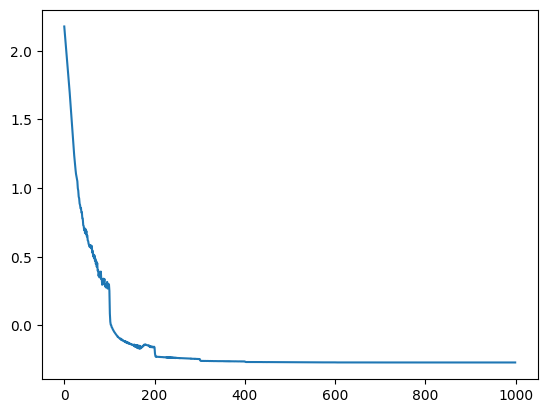

In [60]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [61]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.5183e-01, -1.3322e-01, -2.0637e-01, -1.2219e-01, -1.9548e-01,
          1.3604e-01, -1.9345e-01, -1.1193e-01,  1.5827e-01,  2.2056e-01,
          1.7496e-06, -1.4010e-06,  8.7839e-07,  1.0374e-06, -6.1060e-07,
         -2.7838e-06,  2.8475e-06,  3.7911e-07, -2.3111e-06,  7.0391e-07,
          8.7512e-07, -1.0873e-07,  2.8769e-06, -2.5410e-04, -2.9451e-06,
         -2.9803e-06, -2.7490e-06,  2.7902e-06,  2.3165e-06, -5.7780e-07,
         -1.9395e-06, -2.7497e-06,  1.7564e-02, -1.4396e-06, -1.0705e-06,
          2.3620e-06, -3.5722e-07, -2.7573e-06,  9.7911e-07, -1.6964e-06,
         -1.9379e-06,  2.1675e-06, -2.9829e-06,  3.1651e-06, -2.3506e-06,
         -1.7730e-07, -2.6575e-07,  2.9976e-06, -8.9584e-08,  2.3928e-06,
         -4.7156e-07, -3.1404e-06, -3.0132e-06, -3.0350e-06,  2.9262e-06,
         -1.1855e-06,  3.2959e-06, -6.7694e-07, -4.2672e-07, -2.6923e-06,
         -1.9651e-06,  3.1439e-06, -2.3005e-02, -3.1086e-06,  3.1583e-06,
         -2.3292e-06, -1.8123e-06, -2.

tensor([[-1.5183e-01, -1.3322e-01, -2.0637e-01, -1.2219e-01, -1.9548e-01,
          1.3604e-01, -1.9345e-01, -1.1193e-01,  1.5827e-01,  2.2056e-01,
          1.7496e-06, -1.4010e-06,  8.7839e-07,  1.0374e-06, -6.1060e-07,
         -2.7838e-06,  2.8475e-06,  3.7911e-07, -2.3111e-06,  7.0391e-07,
          8.7512e-07, -1.0873e-07,  2.8769e-06, -2.5410e-04, -2.9451e-06,
         -2.9803e-06, -2.7490e-06,  2.7902e-06,  2.3165e-06, -5.7780e-07,
         -1.9395e-06, -2.7497e-06,  1.7564e-02, -1.4396e-06, -1.0705e-06,
          2.3620e-06, -3.5722e-07, -2.7573e-06,  9.7911e-07, -1.6964e-06,
         -1.9379e-06,  2.1675e-06, -2.9829e-06,  3.1651e-06, -2.3506e-06,
         -1.7730e-07, -2.6575e-07,  2.9976e-06, -8.9584e-08,  2.3928e-06,
         -4.7156e-07, -3.1404e-06, -3.0132e-06, -3.0350e-06,  2.9262e-06,
         -1.1855e-06,  3.2959e-06, -6.7694e-07, -4.2672e-07, -2.6923e-06,
         -1.9651e-06,  3.1439e-06, -2.3005e-02, -3.1086e-06,  3.1583e-06,
         -2.3292e-06, -1.8123e-06, -2.

tensor([[-1.8963e-01, -1.8349e-01, -2.4708e-01, -1.5937e-01,  2.2219e-01,
         -1.6620e-01, -2.6850e-01, -1.5077e-01, -2.2974e-01, -2.7680e-01,
         -4.2572e-07, -9.8758e-09,  1.2918e-07,  2.0422e-06,  4.8717e-07,
         -2.4104e-09,  1.6048e-06,  1.2820e-07,  2.9015e-07, -1.0709e-07,
          5.0306e-08, -3.6767e-08,  5.4612e-07,  1.5340e-02, -6.3888e-08,
          6.2395e-07, -2.9486e-07,  9.4545e-08,  1.6233e-07, -5.8013e-08,
         -7.3480e-08, -1.5366e-09,  3.2363e-02, -6.5356e-08,  6.7423e-08,
         -1.1813e-07,  1.5666e-07, -8.2992e-08,  2.8625e-07, -1.6013e-07,
          1.9075e-07,  4.5066e-08, -7.8528e-07, -1.7275e-09,  5.8267e-08,
          2.2075e-08,  7.6197e-08,  6.2676e-09, -5.9666e-08, -3.5503e-07,
          3.3825e-09,  8.1376e-07, -7.6183e-09, -3.0092e-07, -6.8119e-08,
          1.8307e-07, -2.0896e-08, -4.4642e-09,  2.0474e-09, -5.6007e-08,
         -1.2402e-06, -5.8486e-07, -1.6531e-02,  6.0002e-08,  8.8510e-08,
         -3.6356e-07,  8.8040e-08,  3.

(raylet) [2022-11-13 16:56:41,542 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 365195264; capacity: 29394726912. Object creation will fail if spilling is required.


In [62]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([9.8990e-01, 2.0395e-01, 1.2597e-02, 9.8663e-01, 9.5454e-01, 9.9327e-01,
        9.8132e-01, 6.0911e-05, 9.3948e-01, 9.9280e-01, 7.2009e-03, 9.0436e-01,
        7.6315e-01, 6.2170e-01, 1.1229e-02, 3.4154e-02, 7.5403e-01, 8.8930e-02,
        9.9082e-01, 9.1445e-01, 2.5739e-01, 9.8754e-01, 8.3783e-01, 9.8865e-01,
        1.0137e-01, 9.8157e-01, 1.0974e-01, 2.0260e-01, 8.8719e-01, 1.1032e-02,
        6.9222e-01, 4.2168e-04, 5.1550e-04, 6.7691e-03, 1.9145e-01, 2.5587e-01,
        4.4126e-01, 9.8277e-01, 1.5697e-02, 4.8217e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.])

tensor([7.0881e-02, 7.7741e-01, 1.4806e-02, 7.5130e-02, 1.4597e-02, 1.0578e-01,
        1.5967e-02, 9.9525e-01, 6.2080e-02, 5.6140e-01, 7.9397e-01, 6.6846e-02,
        5.9817e-04, 9.9715e-01, 9.9751e-01, 1.9606e-03, 9.9225e-01, 2.5288e-01,
        7.3324e-02, 9.3822e-01, 5.7919e-01, 9.7132e-01, 4.3852e-04, 9.7062e-01,
        1.9869e-02, 2.3658e-02, 8.3414e-04, 5.9100e-02, 1.1628e-03, 9.9687e-01,
        8.5953e-01, 2.1179e-03, 1.9157e-01, 9.6084e-02, 4.4605e-04, 9.9653e-01,
        5.4495e-01, 9.4831e-01, 9.9555e-01, 9.6167e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1.])

tensor([9.7899e-01, 9.8725e-01, 2.9162e-01, 9.8615e-01, 9.6753e-02, 9.3401e-01,
        2.2406e-01, 5.0669e-01, 9.8847e-01, 5.7245e-02, 9.2781e-01, 6.7344e-05,
        9.9288e-01, 2.8140e-04, 9.7527e-01, 1.1138e-03, 9.8805e-01, 9.9445e-01,
        6.5485e-01, 9.4563e-01, 9.8927e-01, 1.9234e-02, 8.9383e-01, 2.6451e-03,
        1.5141e-02, 1.5302e-01, 9.9248e-01, 9.9635e-01, 9.8619e-01, 4.0382e-01,
        8.1697e-01, 1.3003e-01, 8.9408e-02, 3.2949e-01, 3.6202e-02, 4.7039e-03,
        1.0764e-02, 6.2260e-01, 7.9294e-03, 7.3126e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.])

In [63]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[56,  7],
       [ 5, 52]])

0.9122807017543859

0.8888888888888888

0.9

0.8813559322033898

0.8965517241379309

In [64]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[20,  2],
       [ 0, 18]])

1.0

0.9090909090909091

array([[17,  3],
       [ 5, 15]])

0.75

0.85

array([[19,  2],
       [ 0, 19]])

1.0

0.9047619047619048

In [65]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.51833221e-01, -1.33215427e-01, -2.06365660e-01,
        -1.22193955e-01, -1.95476964e-01,  1.36040792e-01,
        -1.93448275e-01, -1.11931518e-01,  1.58267945e-01,
         2.20560864e-01,  1.74962895e-06, -1.40102691e-06,
         8.78388676e-07,  1.03736113e-06, -6.10601887e-07,
        -2.78381935e-06,  2.84745352e-06,  3.79108741e-07,
        -2.31109220e-06,  7.03909620e-07,  8.75115404e-07,
        -1.08725217e-07,  2.87686407e-06, -2.54098617e-04,
        -2.94512961e-06, -2.98034138e-06, -2.74899890e-06,
         2.79020924e-06,  2.31647732e-06, -5.77797721e-07,
        -1.93948904e-06, -2.74972285e-06,  1.75636001e-02,
        -1.43961029e-06, -1.07049868e-06,  2.36202322e-06,
        -3.57217687e-07, -2.75734737e-06,  9.79114816e-07,
        -1.69643090e-06, -1.93785309e-06,  2.16749572e-06,
        -2.98291479e-06,  3.16514024e-06, -2.35064317e-06,
        -1.77296499e-07, -2.65753698e-07,  2.99758972e-06,
        -8.95839918e-08,  2.39283258e-06, -4.71562657e-0

array([[-1.51833221e-01, -1.33215427e-01, -2.06365660e-01,
        -1.22193955e-01, -1.95476964e-01,  1.36040792e-01,
        -1.93448275e-01, -1.11931518e-01,  1.58267945e-01,
         2.20560864e-01,  1.74962895e-06, -1.40102691e-06,
         8.78388676e-07,  1.03736113e-06, -6.10601887e-07,
        -2.78381935e-06,  2.84745352e-06,  3.79108741e-07,
        -2.31109220e-06,  7.03909620e-07,  8.75115404e-07,
        -1.08725217e-07,  2.87686407e-06, -2.54098617e-04,
        -2.94512961e-06, -2.98034138e-06, -2.74899890e-06,
         2.79020924e-06,  2.31647732e-06, -5.77797721e-07,
        -1.93948904e-06, -2.74972285e-06,  1.75636001e-02,
        -1.43961029e-06, -1.07049868e-06,  2.36202322e-06,
        -3.57217687e-07, -2.75734737e-06,  9.79114816e-07,
        -1.69643090e-06, -1.93785309e-06,  2.16749572e-06,
        -2.98291479e-06,  3.16514024e-06, -2.35064317e-06,
        -1.77296499e-07, -2.65753698e-07,  2.99758972e-06,
        -8.95839918e-08,  2.39283258e-06, -4.71562657e-0

array([[-1.89633310e-01, -1.83490694e-01, -2.47078627e-01,
        -1.59370869e-01,  2.22187653e-01, -1.66202888e-01,
        -2.68502235e-01, -1.50774568e-01, -2.29742929e-01,
        -2.76803613e-01, -4.25715825e-07, -9.87579352e-09,
         1.29177678e-07,  2.04219668e-06,  4.87170496e-07,
        -2.41039966e-09,  1.60484433e-06,  1.28196163e-07,
         2.90150439e-07, -1.07091587e-07,  5.03060420e-08,
        -3.67672399e-08,  5.46122976e-07,  1.53398039e-02,
        -6.38884572e-08,  6.23947983e-07, -2.94858808e-07,
         9.45446601e-08,  1.62327339e-07, -5.80133381e-08,
        -7.34803578e-08, -1.53664426e-09,  3.23629938e-02,
        -6.53559908e-08,  6.74230947e-08, -1.18125499e-07,
         1.56658785e-07, -8.29922939e-08,  2.86248564e-07,
        -1.60134519e-07,  1.90749773e-07,  4.50656223e-08,
        -7.85281145e-07, -1.72750658e-09,  5.82670800e-08,
         2.20751115e-08,  7.61965424e-08,  6.26759844e-09,
        -5.96664833e-08, -3.55031801e-07,  3.38252648e-0

In [69]:
threshold=0.12
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.15183322, -0.13321543, -0.20636566, -0.12219395, -0.19547696,
         0.13604079, -0.19344828, -0.11193152,  0.15826795,  0.22056086,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

10

In [74]:
index=np.nonzero(model_1_weight)[1]
index=index.tolist()
index=set(index)

beta=np.array(beta_1)
trueindex=np.where(beta!=0)[0]
trueindex=trueindex.tolist()
trueindex=set(trueindex)

TP=len(trueindex.intersection(index))
FP=len(index.difference(trueindex))
FN=len(trueindex)-TP
TN=p-len(trueindex)-FP
vsSEN=TP/(TP+FN)#vsSEN.
vsSPE=TN/(TN+FP)#vsSPE
vsSEN
vsSPE
math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP+FN)/(TP+FN+TN+FP)#vsMR
1-vsMR#vsCCR

1.0

1.0

1.0

1.0

(raylet) [2022-11-13 19:24:19,581 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 300584960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:24:29,591 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 300490752; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:24:39,600 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 300429312; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:24:49,609 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 300425216; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 19:29:29,897 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 303640576; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:29:39,903 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 310931456; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:29:49,908 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 316579840; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:29:59,925 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 322568192; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 19:34:40,273 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418463744; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:34:50,281 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418410496; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:35:00,290 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418365440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:35:10,298 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418304000; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 19:39:50,534 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 409341952; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:40:00,540 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 408588288; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:40:10,548 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 408096768; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:40:20,557 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 407965696; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 19:45:00,788 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 419418112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:45:10,797 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 421625856; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:45:20,805 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 423493632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:45:30,814 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 423391232; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 19:50:11,055 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 421031936; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:50:21,064 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 420900864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:50:31,073 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 420782080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:50:41,081 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 420700160; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 19:55:21,326 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418304000; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:55:31,335 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418205696; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:55:41,344 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418123776; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 19:55:51,352 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 418054144; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 20:00:31,596 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 415617024; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:00:41,604 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 415535104; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:00:51,614 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 415469568; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:01:01,622 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 415424512; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 20:05:41,864 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 412917760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:05:51,873 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 412848128; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:06:01,882 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 412803072; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:06:11,890 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 412725248; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 20:10:52,135 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 410251264; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:11:02,144 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 410198016; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:11:12,152 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 410132480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:11:22,161 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 409997312; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 20:16:02,406 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 407609344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:16:12,415 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 407547904; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:16:22,424 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 407433216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:16:32,433 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 407306240; capacity: 29394726912. Object creation will fail i

(raylet) [2022-11-13 20:21:12,677 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 404934656; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:21:22,686 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 404795392; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:21:32,694 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 404676608; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 20:21:42,703 E 20055 20073] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_16-38-28_455250_19938 is over 95% full, available space: 404594688; capacity: 29394726912. Object creation will fail i